In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets py_vncorenlp emoji torchinfo

In [38]:
import transformers 
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datasets import load_dataset

In [39]:
train_df = pd.read_csv('/content/drive/MyDrive/students_feedback_data/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/students_feedback_data/val.csv')

In [40]:
train_df.head()

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,positive,training_program
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",positive,lecturer
2,đi học đầy đủ full điểm chuyên cần .,negative,training_program
3,chưa áp dụng công nghệ thông tin và các thiết ...,negative,lecturer
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",positive,lecturer


In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   14592 non-null  object
 1   sentiment  14592 non-null  object
 2   topic      14592 non-null  object
dtypes: object(3)
memory usage: 342.1+ KB


<Axes: xlabel='topic', ylabel='count'>

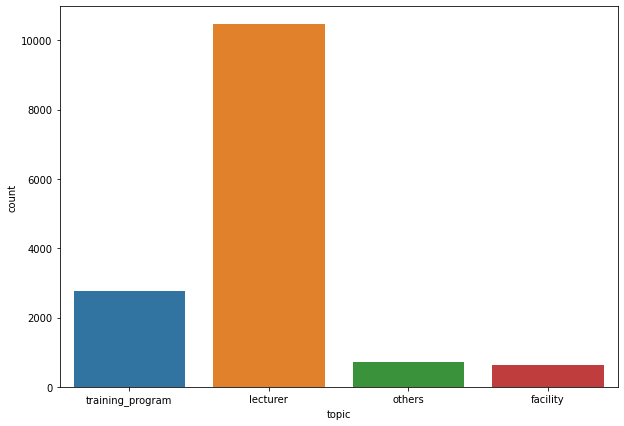

In [42]:
plt.figure(figsize=(10,7))
sns.countplot(x=train_df['topic'])

In [43]:
val_df.head()

,sentence,sentiment,topic
0,giáo trình chưa cụ thể .,negative,training_program
1,giảng buồn ngủ .,negative,lecturer
2,"giáo viên vui tính , tận tâm .",positive,lecturer
3,"giảng viên nên giao bài tập nhiều hơn , chia n...",negative,lecturer
4,"giảng viên cần giảng bài chi tiết hơn , đi sâu...",negative,lecturer


In [44]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   1583 non-null   object
 1   sentiment  1583 non-null   object
 2   topic      1583 non-null   object
dtypes: object(3)
memory usage: 37.2+ KB


<Axes: xlabel='topic', ylabel='count'>

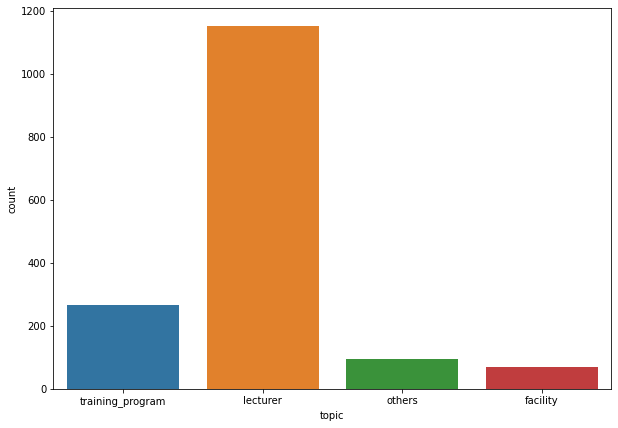

In [45]:
plt.figure(figsize=(10,7))
sns.countplot(x=val_df['topic'])

#Tiền xử lý dữ liệu

In [ ]:
import py_vncorenlp
py_vncorenlp.download_model() 
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"])

In [103]:
import re
import string
import emoji

def preprocessing_text(text, word_segment=True):
  # Biến đổi về chữ thường
  text = text.lower()
  # Loại bỏ biểu tượng
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  # Loại bỏ các dấu câu
  translator = str.maketrans('', '', string.punctuation)
  text = text.translate(translator)
  # Phân đoạn từ bằng py_vncorenlp
  if word_segment == False:
    return text
  text = rdrsegmenter.word_segment(text)

  return " ".join(text).strip()
preprocessing_text("chưa áp dụng công nghệ thông tin và các thiết bị hỗ trợ cho việc giảng dạy .")

'chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy'

In [47]:
train_df['sentence'] = train_df['sentence'].apply(preprocessing_text)
val_df['sentence'] = val_df['sentence'].apply(preprocessing_text)

# Tạo danh sách các câu

In [48]:
train_sentences = train_df['sentence'].tolist()
val_sentences = val_df['sentence'].tolist()

train_sentences[:5]

['slide giáo_trình đầy_đủ',
 'nhiệt_tình giảng_dạy gần_gũi với sinh_viên',
 'đi học đầy_đủ full điểm chuyên_cần',
 'chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy',
 'thầy giảng bài hay có nhiều bài_tập ví_dụ ngay trên lớp']

# Tạo nhãn dạng số

In [50]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["topic"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["topic"].to_numpy())

train_labels_encoded

array([3, 1, 3, ..., 1, 1, 3])

In [51]:
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(4,
 array(['facility', 'lecturer', 'others', 'training_program'], dtype=object))

# Tạo hàm đánh giá các chỉ số

In [52]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

#Model 0: Tạo mô hình cơ sở Tf-idf

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [54]:
model_0_preds = model_0.predict(val_sentences)
model_0_preds

array([1, 1, 1, ..., 1, 3, 1])

In [55]:
calculate_result(y_true=val_labels_encoded,
                 y_pred=model_0_preds)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8085912823752369,
 'precision': 0.7549253670084387,
 'recall': 0.8085912823752369,
 'f1-score': 0.7687042731502941}

#Model: sử dụng phoBERT từ hugging face

In [56]:
id2label = {k:v for k,v in enumerate(class_names)}
label2id = {v:k for k,v in id2label.items()}

train_df['labels'] = train_df['topic'].map(label2id)
val_df['labels'] = val_df['topic'].map(label2id)

In [57]:
train_df2 = train_df[['sentence', 'labels']]
train_df2.to_csv('pre_train_data.csv', index=None)

val_df2 = val_df[['sentence', 'labels']]
val_df2.to_csv('pre_val_data.csv', index=None)


In [58]:
!head pre_train_data.csv

sentence,labels
slide giáo_trình đầy_đủ,3
nhiệt_tình giảng_dạy gần_gũi với sinh_viên,1
đi học đầy_đủ full điểm chuyên_cần,3
chưa áp_dụng công_nghệ_thông_tin và các thiết_bị hỗ_trợ cho việc giảng_dạy,1
thầy giảng bài hay có nhiều bài_tập ví_dụ ngay trên lớp,1
giảng_viên đảm_bảo thời_gian lên_lớp tích_cực trả_lời câu hỏi của sinh_viên thường_xuyên đặt câu hỏi cho sinh_viên,1
em sẽ nợ môn này nhưng em sẽ học lại ở các học_kỳ kế_tiếp,2
thời_lượng học quá dài không đảm_bảo tiếp_thu hiệu_quả,3
nội_dung môn_học có phần thiếu trọng_tâm hầu_như là chung_chung khái_quát khiến sinh_viên rất khó nắm được nội_dung môn_học,3


In [59]:
from datasets import load_dataset

ds = load_dataset('csv', data_files={'train': 'pre_train_data.csv',
                                     'validation':'pre_val_data.csv'})
ds

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-222bcaa2bc92c14d/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels'],
        num_rows: 14592
    })
    validation: Dataset({
        features: ['sentence', 'labels'],
        num_rows: 1583
    })
})

In [71]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

In [72]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

tokenized_ds = ds.map(tokenize_fn, batched=True)
tokenized_ds

Map:   0%|          | 0/14592 [00:00<?, ? examples/s]

Map:   0%|          | 0/1583 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 14592
    })
    validation: Dataset({
        features: ['sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1583
    })
})

In [73]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [74]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
RobertaForSequenceClassification                             --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   49,152,768
│    │    └─Embedding: 3-2                                   198,144
│    │    └─Embedding: 3-3                                   768
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  85,054,464
├─RobertaClassificationHead: 1-2                             --
│    └─Linear: 2-3                                           590,592
│    └─Dropout: 2-4                                          --
│    └─Linear: 2-5                                           3,076
To

In [75]:
from transformers import TrainingArguments

save_checkpoint = 'student_feedback_model'
training_args = TrainingArguments(
    output_dir=save_checkpoint,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8

)

In [77]:
#Định nghĩa hàm đánh giá các chỉ số
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = accuracy_score(labels, predictions)
  f1 = f1_score(labels, predictions, average='weighted')
  return {'accuracy': acc, 'f1': f1}

In [78]:
from transformers import Trainer 
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [79]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.443900,0.326338,0.883765,0.877985
2,0.287200,0.317660,0.898294,0.894951
3,0.213700,0.328369,0.900190,0.896806
4,0.161000,0.446172,0.893241,0.893503
5,0.098200,0.482174,0.895136,0.894311


TrainOutput(global_step=4560, training_loss=0.22668606795762714, metrics={'train_runtime': 683.7779, 'train_samples_per_second': 106.701, 'train_steps_per_second': 6.669, 'total_flos': 1172378137162752.0, 'train_loss': 0.22668606795762714, 'epoch': 5.0})

- Sau 3 epoch có vẻ như model đang bị overfitting. Nên chúng ta sẽ sử dụng model của epoch thứ 3 có accuracy và f1 cao nhất

#Lưu và sử dụng model

In [80]:
!ls student_feedback_model

checkpoint-1824  checkpoint-3648  checkpoint-912
checkpoint-2736  checkpoint-4560  runs


In [81]:
from transformers import pipeline

In [90]:
saved_model = pipeline('text-classification',
                       model='student_feedback_model/checkpoint-2736')

In [91]:
test_pred = saved_model(ds['validation']['sentence'])

In [93]:
test_pred = [label2id[d['label']] for d in test_pred]

In [94]:
calculate_result(ds['validation']['labels'], test_pred)

{'accuracy': 0.9001895135818067,
 'precision': 0.8960072748011253,
 'recall': 0.9001895135818067,
 'f1-score': 0.8968059396638728}

In [95]:
def plot_cm(cm):
  plt.figure(figsize=(9,6))
  df_cm = pd.DataFrame(cm, index=label2id.keys(), columns=label2id.keys())
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

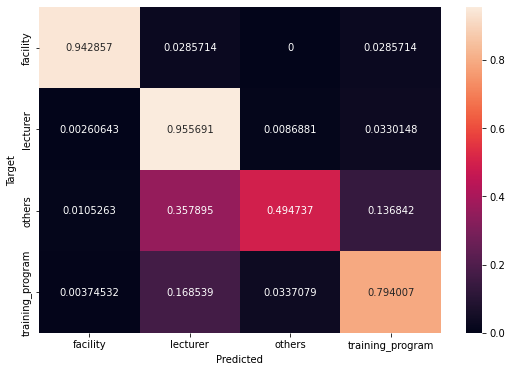

In [96]:
cm = confusion_matrix(ds['validation']['labels'], test_pred, normalize='true')
plot_cm(cm)

- Model dự đoán tốt cho hai lớp facility và lecturer
- Dự đoán tệ nhất ở lớp others
- Điều này sảy ra là bởi dữ liệu đào tạo bị mất cân bằng và có nhiều dữ liệu cho hai lớp facility và lecturer
- Khi dự đoán lớp others thường nhầm lẫn với lớp lecturer 

In [97]:
text = "tôi không thể nào hiểu được môn học của thầy Chu Nguyên Châu"
saved_model(preprocessing_text(text))

[{'label': 'lecturer', 'score': 0.8827672600746155}]

In [98]:
text = "phòng học này cũ quá rồi. cần phải sửa lại thôi"
saved_model(preprocessing_text(text))

[{'label': 'facility', 'score': 0.9934822916984558}]

In [99]:
text = "hôm nay trời mưa"
saved_model(preprocessing_text(text))

[{'label': 'others', 'score': 0.9463704824447632}]

In [102]:
text = "Giáo trình của môn vật lý 1 cũ quá rồi"
saved_model(preprocessing_text(text))

[{'label': 'training_program', 'score': 0.9157381057739258}]

In [101]:
text = "phòng học trường mình vào mùa hè thì nóng, mùa đông thì lạnh"
saved_model(preprocessing_text(text))

[{'label': 'facility', 'score': 0.9930907487869263}]